In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import json
import pandas as pd

with open('user-wallet-transactions.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.head())

                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...   

 

In [5]:
# Count of each action per wallet
wallet_actions = df.groupby(['userWallet', 'action']).size().unstack(fill_value=0)

# Rename columns for easier handling
wallet_actions.columns = ['num_borrows' if 'borrow' in col else
                          'num_repayments' if 'repay' in col else
                          'num_liquidations' if 'liquidation' in col else
                          'num_withdrawals' if 'redeem' in col else
                          'num_deposits' for col in wallet_actions.columns]

# Fill missing possible columns
for col in ['num_borrows', 'num_repayments', 'num_liquidations', 'num_withdrawals', 'num_deposits']:
    if col not in wallet_actions.columns:
        wallet_actions[col] = 0

# Add total actions
wallet_actions['total_transactions'] = wallet_actions.sum(axis=1)

# Add borrow/repay ratio (handle divide-by-zero cases)
wallet_actions['borrow_repay_ratio'] = wallet_actions.apply(
    lambda row: row['num_borrows'] / row['num_repayments'] if row['num_repayments'] > 0 else 999,
    axis=1
)

wallet_actions.reset_index(inplace=True)

print(wallet_actions.head())

                                   userWallet  num_borrows  num_deposits  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6            0             1   
1  0x000000000051d07a4fb3bd10121a343d85818da6            0             1   
2  0x000000000096026fb41fc39f9875d164bd82e2dc            0             2   
3  0x0000000000e189dd664b9ab08a33c4839953852c            0             0   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee           15           250   

   num_liquidations  num_withdrawals  num_repayments  total_transactions  \
0                 0                0               0                   1   
1                 0                0               0                   1   
2                 0                0               0                   2   
3                 0               17               0                  17   
4                 0              130               4                 399   

   borrow_repay_ratio  
0              999.00  
1              999.00  
2             

In [6]:
def calculate_score(row):
    score = 400  # base score

    # Good behaviors
    score += row['num_deposits'] * 5
    score += row['num_repayments'] * 10

    # Risky behaviors
    score -= row['num_borrows'] * 2
    score -= row['num_liquidations'] * 100

    # Heavily penalize if they borrowed more than they repaid
    if row['borrow_repay_ratio'] > 1.5 and row['num_borrows'] > 0:
        score -= 100

    # Keep the score in the 0–1000 range
    return max(0, min(score, 1000))

wallet_actions['credit_score'] = wallet_actions.apply(calculate_score, axis=1)
print(wallet_actions[['userWallet', 'credit_score']].head())

                                   userWallet  credit_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           405
1  0x000000000051d07a4fb3bd10121a343d85818da6           405
2  0x000000000096026fb41fc39f9875d164bd82e2dc           410
3  0x0000000000e189dd664b9ab08a33c4839953852c           400
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee          1000


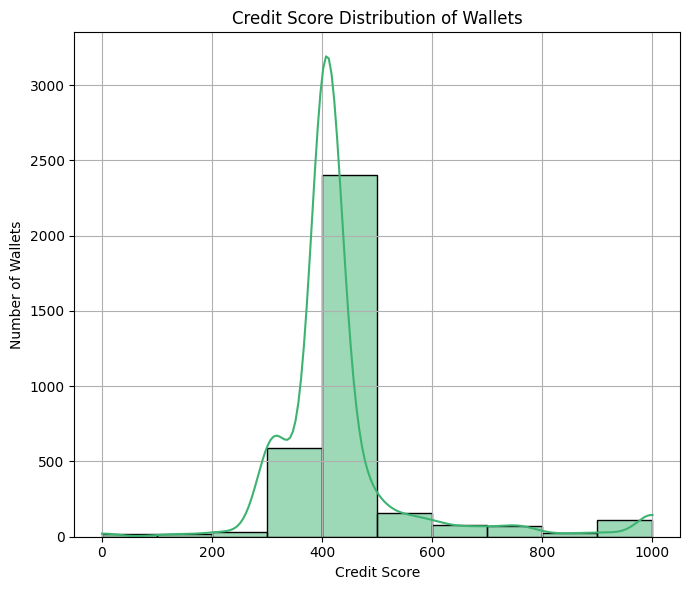

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
sns.histplot(wallet_actions['credit_score'], bins=10, kde=True, color='mediumseagreen')
plt.title("Credit Score Distribution of Wallets")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.savefig("score_distribution.png")
plt.show()

In [8]:
bins = [0,100,200,300,400,500,600,700,800,900,1000]
wallet_actions['score_range'] = pd.cut(wallet_actions['credit_score'], bins)

score_distribution = wallet_actions['score_range'].value_counts().sort_index()
print(score_distribution)

score_range
(0, 100]          4
(100, 200]       17
(200, 300]       32
(300, 400]      732
(400, 500]     2263
(500, 600]      155
(600, 700]       76
(700, 800]       70
(800, 900]       23
(900, 1000]     114
Name: count, dtype: int64
